In [ ]:
!pip install ultralytics albumentations -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 977.1/977.1 kB 16.6 MB/s eta 0:00:00


Import thư viện


In [2]:
import os
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import glob
from IPython.display import display, Image
import numpy as np
import yaml
from PIL import Image as PILImage
import albumentations as A
import shutil
from pathlib import Path

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Data Preprocessing

In [3]:
main_path = '/kaggle/input/football-players-detection-dataset'
data_yaml_path = '/kaggle/input/football-players-detection-dataset/data.yaml'
class_names = ["ball", "goalkeeper", "player", "referee"]

In [4]:
work_dir = '/kaggle/working/football_detection_improved'
os.makedirs(work_dir, exist_ok=True)

In [5]:
with open(data_yaml_path, 'r') as file:
    data_cfg = yaml.safe_load(file)
    
print("Dataset configuration:")
print(data_cfg)

Dataset configuration:
{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 4, 'names': ['ball', 'goalkeeper', 'player', 'referee'], 'roboflow': {'workspace': 'roboflow-jvuqo', 'project': 'football-players-detection-3zvbc', 'version': 9, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc/dataset/9'}}


In [6]:
model_variant = 'yolov8m.pt'

In [ ]:
IMG_SIZE = 1280 
BATCH_SIZE = 8   
EPOCHS = 50     
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005
CONF_THRESHOLD = 0.25  
NMS_IOU_THRESHOLD = 0.5

In [8]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
custom_data_yaml = os.path.join(work_dir, 'custom_data.yaml')
with open(data_yaml_path, 'r') as infile, open(custom_data_yaml, 'w') as outfile:
    data = yaml.safe_load(infile)
    # Thêm class weights để tập trung hơn vào các lớp hiếm
    # Tăng trọng số cho ball(0), goalkeeper(1) và referee(3) do các lớp này ít xuất hiện -> loss function phạt nặng hơn
    data['class_weights'] = [5.0, 3.0, 1.0, 4.0]  
    yaml.dump(data, outfile)

Augmentation data

In [ ]:
def create_augmented_dataset():    
    aug_dir = os.path.join(work_dir, 'augmented_dataset')
    
    train_images_dir = os.path.join(aug_dir, 'train', 'images')
    train_labels_dir = os.path.join(aug_dir, 'train', 'labels')
    val_images_dir = os.path.join(aug_dir, 'valid', 'images')  
    val_labels_dir = os.path.join(aug_dir, 'valid', 'labels')
    
    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(train_labels_dir, exist_ok=True)
    os.makedirs(val_images_dir, exist_ok=True)
    os.makedirs(val_labels_dir, exist_ok=True)
    
    train_img_dir = os.path.join(main_path, 'train', 'images')
    train_label_dir = os.path.join(main_path, 'train', 'labels')
    
    img_files = sorted(glob.glob(os.path.join(train_img_dir, '*.*')))
    print(f"Tìm thấy {len(img_files)} ảnh huấn luyện gốc")
    
    # augmentation data
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.RandomScale(scale_limit=0.2, p=0.4),
        A.Blur(blur_limit=3, p=0.2),
        A.MotionBlur(blur_limit=3, p=0.2),  
    ])
    
    # Copy và augment các file train
    for img_path in img_files:
        img_name = os.path.basename(img_path)
        label_name = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(train_label_dir, label_name)
        
        shutil.copy(img_path, os.path.join(train_images_dir, img_name))
        shutil.copy(label_path, os.path.join(train_labels_dir, label_name))
        
        # Đọc nội dung label để xác định xem file có chứa các đối tượng hiếm không
        with open(label_path, 'r') as f:
            labels = f.readlines()
        
        has_rare_class = False
        for label in labels:
            class_id = int(label.split()[0])
            if class_id in [0, 1, 3]:  # ball, goalkeeper, referee
                has_rare_class = True
                break
        
        # Nếu có các đối tượng hiếm, thực hiện tăng cường dữ liệu
        if has_rare_class:
            img = np.array(PILImage.open(img_path))
            
            # Tạo 3 phiên bản tăng cường cho mỗi ảnh có đối tượng hiếm
            for i in range(3):
                augmented = transform(image=img)
                aug_img = augmented['image']
                
                aug_img_name = f"aug_{i}_{img_name}"
                PILImage.fromarray(aug_img).save(os.path.join(train_images_dir, aug_img_name))
                
                aug_label_name = f"aug_{i}_{label_name}"
                shutil.copy(label_path, os.path.join(train_labels_dir, aug_label_name))
    
    val_img_dir = os.path.join(main_path, 'valid', 'images') 
    val_label_dir = os.path.join(main_path, 'valid', 'labels')
    
    val_files = sorted(glob.glob(os.path.join(val_img_dir, '*.*')))
    print(f"Tìm thấy {len(val_files)} ảnh validation gốc")
    
    for img_path in val_files:
        img_name = os.path.basename(img_path)
        label_name = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(val_label_dir, label_name)
        
        shutil.copy(img_path, os.path.join(val_images_dir, img_name))
        if os.path.exists(label_path):  # Check if label exists
            shutil.copy(label_path, os.path.join(val_labels_dir, label_name))
    
    # Cập nhật file data.yaml với đường dẫn mới
    aug_data_yaml = os.path.join(aug_dir, 'data.yaml')
    with open(custom_data_yaml, 'r') as infile, open(aug_data_yaml, 'w') as outfile:
        data = yaml.safe_load(infile)
        data['train'] = train_images_dir  
        data['val'] = val_images_dir      
        data['path'] = aug_dir            
        data['names'] = class_names      
        data['nc'] = len(class_names)   
        yaml.dump(data, outfile)
    
    return aug_data_yaml

In [11]:
augmented_data_yaml = create_augmented_dataset()


Tìm thấy 250 ảnh huấn luyện gốc
Tìm thấy 43 ảnh validation gốc


In [12]:
print("\nKiểm tra nội dung YAML:")
with open(augmented_data_yaml, 'r') as f:
    print(f.read())



Kiểm tra nội dung YAML:
class_weights:
- 5.0
- 3.0
- 1.0
- 4.0
names:
- ball
- goalkeeper
- player
- referee
nc: 4
path: /kaggle/working/football_detection_improved/augmented_dataset
roboflow:
  license: CC BY 4.0
  project: football-players-detection-3zvbc
  url: https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc/dataset/9
  version: 9
  workspace: roboflow-jvuqo
test: ../test/images
train: /kaggle/working/football_detection_improved/augmented_dataset/train/images
val: /kaggle/working/football_detection_improved/augmented_dataset/valid/images



Model 

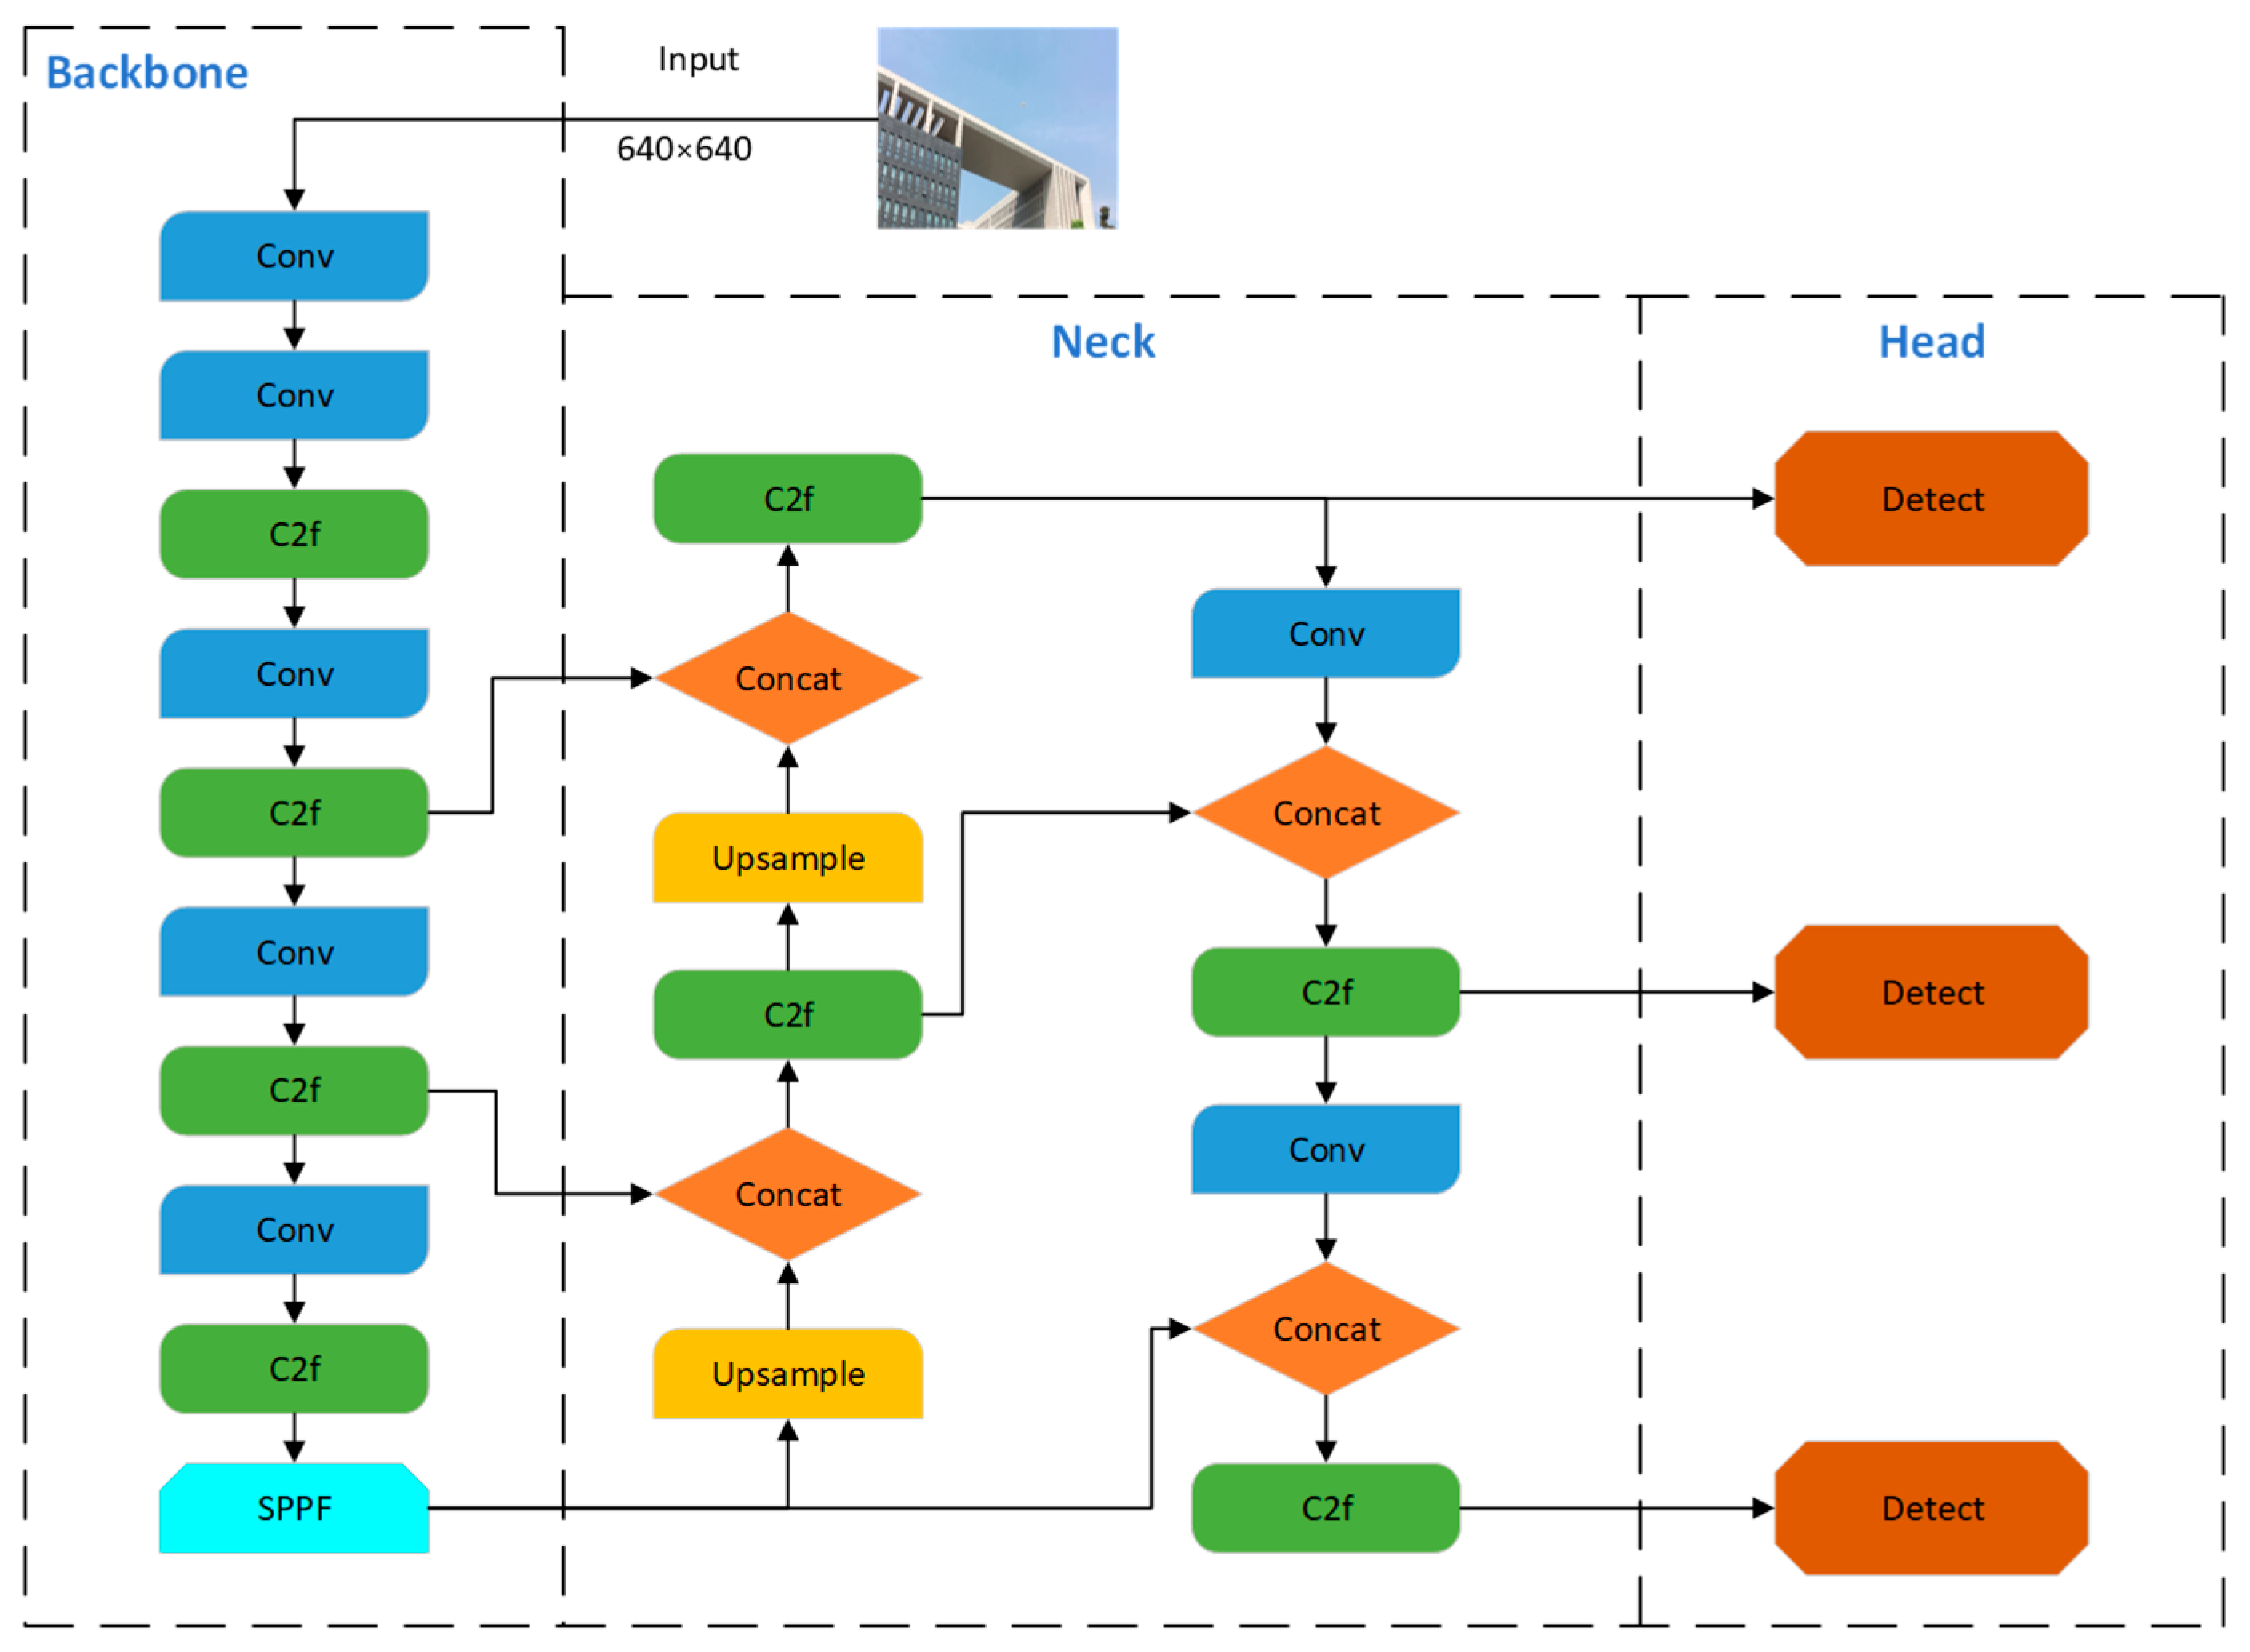

In [13]:
model = YOLO(model_variant)
model.to(DEVICE)


100%|██████████| 49.7M/49.7M [00:00<00:00, 91.3MB/s]


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_

Train

In [ ]:
results_train = model.train(
    data=augmented_data_yaml,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    device=DEVICE,
    name='yolov8_football_detection_improved',
    weight_decay=WEIGHT_DECAY,
    lr0=LEARNING_RATE,
    lrf=0.01,   # Hệ số tốc độ học cuối cùng (lr cuối = lr0 * lrf)
    mosaic=1.0,   # Bật augmentation Mosaic (ghép 4 ảnh) với xác suất 100%
    mixup=0.2,   # Bật augmentation Mixup (trộn ảnh & nhãn) với xác suất 20%
    copy_paste=0.3,
    fliplr=0.5,  # Lật ngang ảnh để tạo biến thể
    scale=0.25,  # Thay đổi tỷ lệ để phát hiện tốt hơn với các đối tượng ở quy mô khác nhau
    degrees=5.0,  # Xoay ảnh nhẹ (phù hợp cho thể thao)
    exist_ok=True,
    patience=15,  # Số epochs chờ đợi nếu không cải thiện trước khi dừng sớm (Early Stopping)
    save_period=5  # Lưu checkpoint mỗi 5 epochs
)

print("\n--- Huấn Luyện Hoàn Tất ---")
print(f"Kết quả huấn luyện được lưu tại: {results_train.save_dir}")

Ultralytics 8.3.100 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/working/football_detection_improved/augmented_dataset/data.yaml, epochs=50, time=None, patience=15, batch=8, imgsz=1280, save=True, save_period=5, cache=False, device=cuda, workers=8, project=None, name=yolov8_football_detection_improved, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_c

100%|██████████| 755k/755k [00:00<00:00, 5.33MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:01<00:00, 4.18MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/football_detection_improved/augmented_dataset/train/labels... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:01<00:00, 921.37it/s]


train: New cache created: /kaggle/working/football_detection_improved/augmented_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/football_detection_improved/augmented_dataset/valid/labels... 43 images, 0 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<00:00, 699.06it/s]

val: New cache created: /kaggle/working/football_detection_improved/augmented_dataset/valid/labels.cache


Plotting labels to runs/detect/yolov8_football_detection_improved/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8_football_detection_improved
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      14.4G      1.282       1.69      1.014        324       1280: 100%|██████████| 125/125 [02:09<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.00it/s]

                   all         43       1025      0.625      0.604      0.659      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      13.7G      1.224      1.355      0.975        527       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         43       1025      0.933      0.778      0.846      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      12.9G      1.237      1.336      0.979        444       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]

                   all         43       1025      0.818       0.78      0.833      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      12.9G      1.226      1.329     0.9815        335       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                   all         43       1025       0.89      0.784      0.859      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      12.9G      1.211      1.246      0.967        439       1280: 100%|██████████| 125/125 [02:12<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                   all         43       1025      0.824      0.836      0.839      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      12.9G      1.204      1.261     0.9622        338       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]

                   all         43       1025      0.892      0.796      0.856      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      12.9G       1.17      1.226     0.9554        381       1280: 100%|██████████| 125/125 [02:12<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                   all         43       1025      0.861      0.821      0.859      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      12.9G      1.157      1.201     0.9495        287       1280: 100%|██████████| 125/125 [02:13<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         43       1025      0.859      0.793      0.861      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      12.9G      1.119      1.147     0.9429        351       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all         43       1025      0.853      0.833      0.862      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      13.5G      1.162      1.253     0.9561        434       1280: 100%|██████████| 125/125 [02:12<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]

                   all         43       1025      0.876      0.798      0.857       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      14.5G       1.12       1.19     0.9406        439       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         43       1025      0.926      0.798      0.846      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      12.3G      1.108      1.204     0.9396        309       1280: 100%|██████████| 125/125 [02:12<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all         43       1025      0.862      0.841      0.847      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      12.9G      1.121      1.166      0.938        388       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]

                   all         43       1025      0.883      0.811      0.867      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      13.5G      1.104      1.164     0.9379        384       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         43       1025      0.869      0.815      0.855      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      13.4G      1.124      1.157     0.9366        459       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all         43       1025      0.891       0.81      0.863      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      13.4G      1.093       1.17      0.938        319       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         43       1025      0.863      0.813      0.856      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50        13G      1.108      1.169     0.9381        310       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all         43       1025      0.928      0.826      0.869      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      14.1G      1.059      1.131     0.9274        310       1280: 100%|██████████| 125/125 [02:12<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         43       1025      0.924      0.825      0.878      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      12.3G      1.103      1.218     0.9371        334       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                   all         43       1025      0.877      0.795      0.854      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      12.3G      1.067      1.169     0.9309        374       1280: 100%|██████████| 125/125 [02:12<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                   all         43       1025      0.965      0.786      0.876      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      12.3G      1.056      1.146     0.9273        384       1280: 100%|██████████| 125/125 [02:12<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                   all         43       1025      0.928      0.805      0.864      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      12.3G      1.049      1.126     0.9256        371       1280: 100%|██████████| 125/125 [02:13<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         43       1025      0.954      0.806      0.872       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      12.3G      1.055      1.164     0.9316        356       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                   all         43       1025      0.937       0.79       0.86      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      12.3G      1.041      1.147     0.9216        365       1280: 100%|██████████| 125/125 [02:12<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                   all         43       1025      0.939      0.822      0.867      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      12.3G      1.053      1.125     0.9224        369       1280: 100%|██████████| 125/125 [02:12<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                   all         43       1025      0.902      0.789      0.858       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      12.3G      1.048      1.162     0.9238        383       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all         43       1025      0.942      0.826      0.879      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      12.3G     0.9945      1.045      0.907        284       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]

                   all         43       1025      0.936      0.836      0.883      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      12.3G      1.015      1.101     0.9205        356       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         43       1025      0.943      0.852      0.883      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      12.3G      1.024      1.143     0.9243        425       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         43       1025      0.958      0.844      0.887      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      12.3G      1.015      1.078     0.9127        314       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all         43       1025      0.931       0.81      0.877      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      12.9G      1.019      1.109     0.9225        329       1280: 100%|██████████| 125/125 [02:13<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                   all         43       1025      0.921      0.843      0.871      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      12.9G     0.9801       1.06      0.908        385       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         43       1025      0.916      0.832       0.87       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      12.9G     0.9901      1.056     0.9135        349       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all         43       1025      0.895      0.847      0.872      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      12.9G       1.01      1.096     0.9158        363       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]

                   all         43       1025      0.895      0.818      0.846      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      12.9G      1.017       1.14     0.9229        336       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                   all         43       1025      0.931      0.819       0.88      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      12.9G      1.011      1.119     0.9209        343       1280: 100%|██████████| 125/125 [02:13<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                   all         43       1025      0.913      0.832      0.878      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      12.9G     0.9639      1.053     0.9099        248       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         43       1025      0.935      0.799      0.871      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      12.9G     0.9577      1.017     0.9033        359       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                   all         43       1025      0.937       0.82      0.877       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      12.9G     0.9519      1.023     0.9031        339       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                   all         43       1025      0.907      0.846      0.876      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      12.9G     0.9729      1.083     0.9094        427       1280: 100%|██████████| 125/125 [02:13<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                   all         43       1025      0.931      0.826      0.855      0.612


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      12.9G     0.9163      1.071     0.9009        191       1280: 100%|██████████| 125/125 [02:10<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all         43       1025      0.927      0.817       0.87      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      12.9G     0.9098      1.059     0.8972        193       1280: 100%|██████████| 125/125 [02:09<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]

                   all         43       1025      0.894      0.827      0.868      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      12.9G     0.9057      1.048     0.8989        185       1280: 100%|██████████| 125/125 [02:08<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]

                   all         43       1025      0.912      0.809      0.871      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      12.9G     0.8768      1.021     0.8933        186       1280: 100%|██████████| 125/125 [02:09<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                   all         43       1025      0.888      0.835      0.873      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      12.9G     0.8657      1.015      0.888        190       1280: 100%|██████████| 125/125 [02:09<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                   all         43       1025      0.903      0.802      0.851      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      12.9G     0.8588     0.9941     0.8882        194       1280: 100%|██████████| 125/125 [02:08<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

                   all         43       1025      0.923      0.792      0.857       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      12.9G      0.864     0.9962     0.8833        189       1280: 100%|██████████| 125/125 [02:09<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                   all         43       1025      0.893      0.839      0.872      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      12.9G     0.8465     0.9871     0.8847        194       1280: 100%|██████████| 125/125 [02:09<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]

                   all         43       1025      0.906      0.845      0.874      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      12.9G     0.8344     0.9611     0.8768        195       1280: 100%|██████████| 125/125 [02:09<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]

                   all         43       1025        0.9      0.827      0.873      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      12.9G     0.8307     0.9484     0.8751        188       1280: 100%|██████████| 125/125 [02:09<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         43       1025       0.91      0.836      0.873      0.623



50 epochs completed in 1.872 hours.
Optimizer stripped from runs/detect/yolov8_football_detection_improved/weights/last.pt, 52.1MB
Optimizer stripped from runs/detect/yolov8_football_detection_improved/weights/best.pt, 52.1MB

Validating runs/detect/yolov8_football_detection_improved/weights/best.pt...
Ultralytics 8.3.100 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


                   all         43       1025      0.937       0.82      0.877      0.639
                  ball         39         39      0.903      0.478      0.625      0.376
            goalkeeper         32         32      0.903      0.873      0.912      0.713
                player         43        853      0.981      0.984      0.993      0.804
               referee         43        101       0.96      0.947      0.979      0.663


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.5ms preprocess, 24.7ms inference, 0.0ms loss, 5.8ms postprocess per image
Results saved to runs/detect/yolov8_football_detection_improved

--- Huấn Luyện Hoàn Tất ---
Kết quả huấn luyện được lưu tại: runs/detect/yolov8_football_detection_improved


Validation 

In [15]:
results_val = model.val(
    data=augmented_data_yaml,
    split='val',
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    conf=CONF_THRESHOLD,
    iou=NMS_IOU_THRESHOLD,
    device=DEVICE
)

print("\n--- Kết quả Đánh Giá Validation ---")
print(f"mAP50-95: {results_val.box.map:.4f}")
print(f"mAP50:    {results_val.box.map50:.4f}")
print("Chi tiết từng lớp:")
for i, class_name in enumerate(class_names):
    try:
        class_precision = results_val.box.p[i]
        class_recall = results_val.box.r[i]
        class_map50 = results_val.box.maps[i]
        print(f"{class_name}: Precision={class_precision:.4f}, Recall={class_recall:.4f}, mAP50={class_map50:.4f}")
    except:
        print(f"{class_name}: Không có dữ liệu")

Ultralytics 8.3.100 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /kaggle/working/football_detection_improved/augmented_dataset/valid/labels.cache... 43 images, 0 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]


                   all         43       1025       0.94      0.817      0.891      0.683
                  ball         39         39        0.9      0.462       0.69      0.438
            goalkeeper         32         32      0.903      0.875      0.922      0.738
                player         43        853      0.988      0.981       0.99      0.851
               referee         43        101       0.97       0.95      0.965      0.705


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 8.5ms preprocess, 56.1ms inference, 0.2ms loss, 8.0ms postprocess per image
Results saved to runs/detect/yolov8_football_detection_improved

--- Kết quả Đánh Giá Validation ---
mAP50-95: 0.6830
mAP50:    0.8915
Chi tiết từng lớp:
ball: Precision=0.9000, Recall=0.4615, mAP50=0.4382
goalkeeper: Precision=0.9032, Recall=0.8750, mAP50=0.7380
player: Precision=0.9882, Recall=0.9812, mAP50=0.8508
referee: Precision=0.9697, Recall=0.9505, mAP50=0.7051


Test

In [16]:
try:
    results_test = model.val(
        data=augmented_data_yaml,
        split='test',
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        conf=CONF_THRESHOLD,
        iou=NMS_IOU_THRESHOLD,
        device=DEVICE
    )
    print("\n--- Kết quả Đánh Giá Test ---")
    print(f"mAP50-95 (Test): {results_test.box.map:.4f}")
    print(f"mAP50 (Test):    {results_test.box.map50:.4f}")
except Exception as e:
    print(f"Không thể đánh giá trên tập test. Lỗi: {e}")

Ultralytics 8.3.100 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Không thể đánh giá trên tập test. Lỗi: val: Error loading data from /kaggle/working/football_detection_improved/augmented_dataset/test/images
See https://docs.ultralytics.com/datasets for dataset formatting guidance.


In [ ]:
def ensemble_predictions(image_path, models, conf_threshold=0.25, iou_threshold=0.5):
    all_boxes = []
    all_scores = []
    all_classes = []
    
    for model in models:
        results = model.predict(
            source=image_path,
            imgsz=IMG_SIZE,
            conf=conf_threshold,
            iou=iou_threshold,
            device=DEVICE,
            save=False
        )[0]

        if results.boxes.xyxy.shape[0] > 0:
            all_boxes.extend(results.boxes.xyxy.cpu().numpy())
            all_scores.extend(results.boxes.conf.cpu().numpy())
            all_classes.extend(results.boxes.cls.cpu().numpy())
    
    return np.array(all_boxes), np.array(all_scores), np.array(all_classes)

Load best model

In [ ]:
best_model_path = os.path.join(results_train.save_dir, 'weights/best.pt')
last_model_path = os.path.join(results_train.save_dir, 'weights/last.pt')

models = []
if os.path.exists(best_model_path):
    print(f"Loading best model from: {best_model_path}")
    best_model = YOLO(best_model_path)
    best_model.to(DEVICE)
    models.append(best_model)

if os.path.exists(last_model_path):
    print(f"Loading last model from: {last_model_path}")
    last_model = YOLO(last_model_path)
    last_model.to(DEVICE)
    models.append(last_model)

if len(models) == 0:
    print("Không tìm thấy models đã lưu, sử dụng model hiện tại.")
    models = [model]


Loading best model from: runs/detect/yolov8_football_detection_improved/weights/best.pt
Loading last model from: runs/detect/yolov8_football_detection_improved/weights/last.pt


Visualize predicted images


Predicting on: /kaggle/input/football-players-detection-dataset/test/images/08fd33_3_6_png.rf.8be10169272238a48652496ad4824d2e.jpg

image 1/1 /kaggle/input/football-players-detection-dataset/test/images/08fd33_3_6_png.rf.8be10169272238a48652496ad4824d2e.jpg: 736x1280 1 ball, 20 players, 2 referees, 223.5ms
Speed: 6.7ms preprocess, 223.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


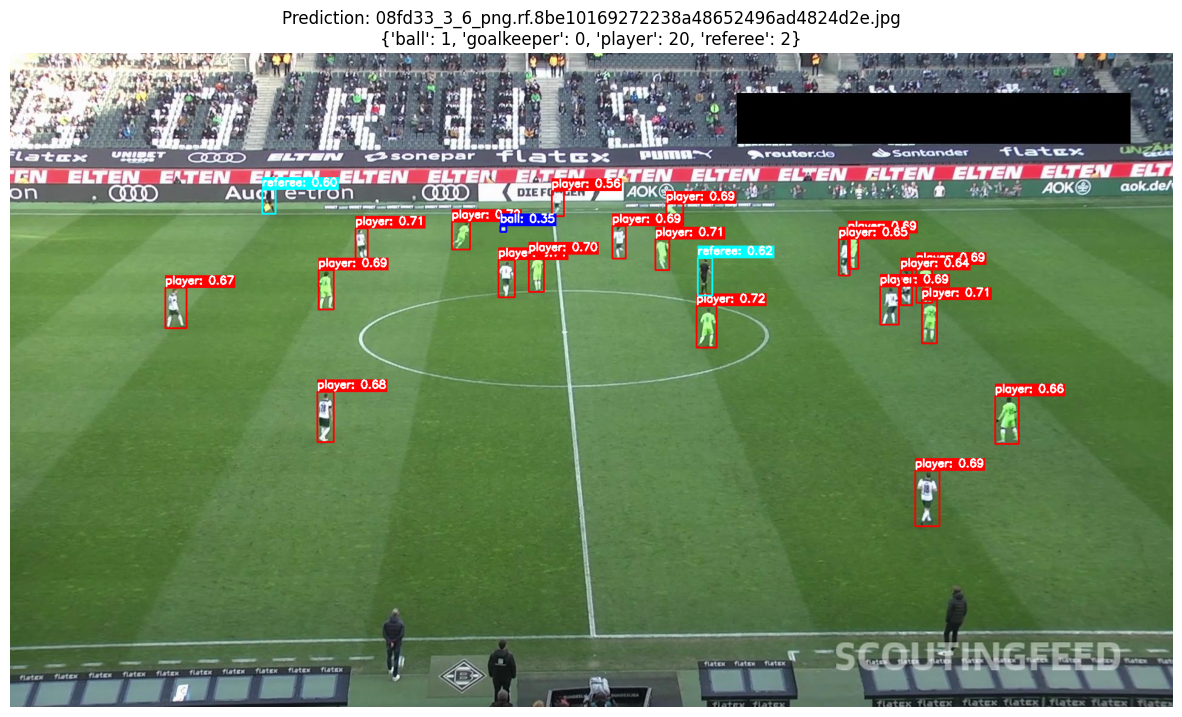


Predicting on: /kaggle/input/football-players-detection-dataset/test/images/40cd38_7_6_png.rf.68ef7fcd663cdf0f5b96bacdbcd94e07.jpg

image 1/1 /kaggle/input/football-players-detection-dataset/test/images/40cd38_7_6_png.rf.68ef7fcd663cdf0f5b96bacdbcd94e07.jpg: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 113.7ms
Speed: 6.8ms preprocess, 113.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


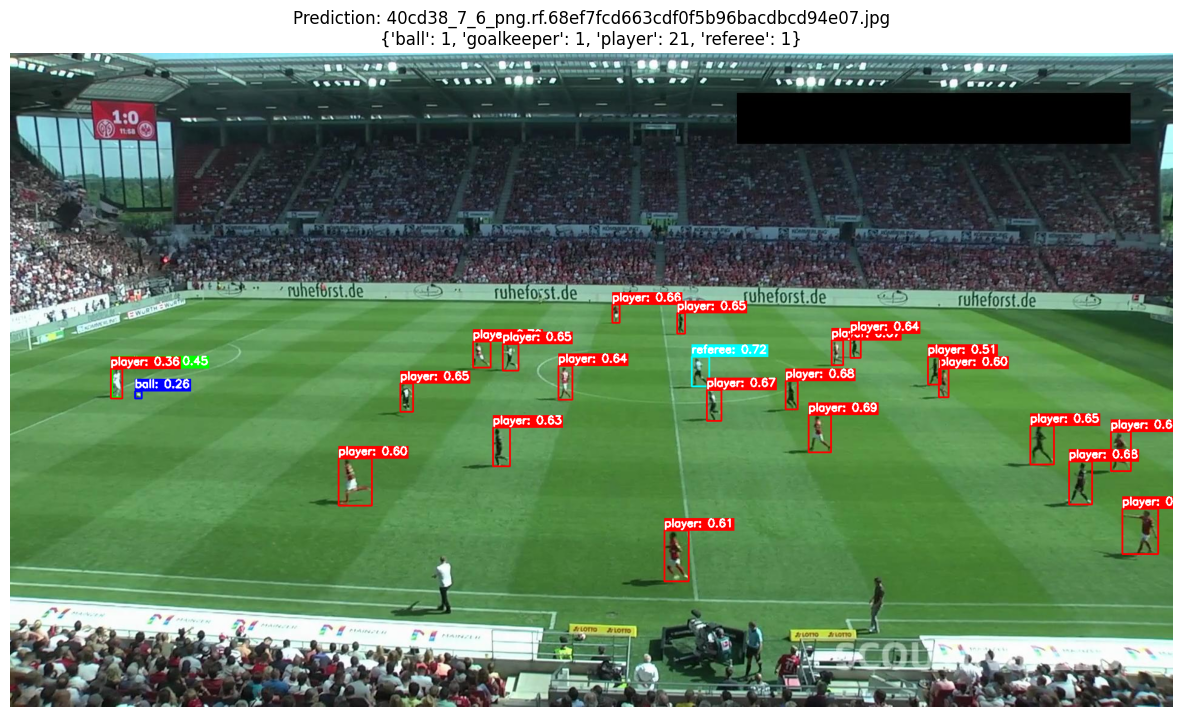


Predicting on: /kaggle/input/football-players-detection-dataset/test/images/42ba34_1_5_png.rf.4337fde8fbe3640cf4351fb41ac9c3ca.jpg

image 1/1 /kaggle/input/football-players-detection-dataset/test/images/42ba34_1_5_png.rf.4337fde8fbe3640cf4351fb41ac9c3ca.jpg: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 113.1ms
Speed: 7.3ms preprocess, 113.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


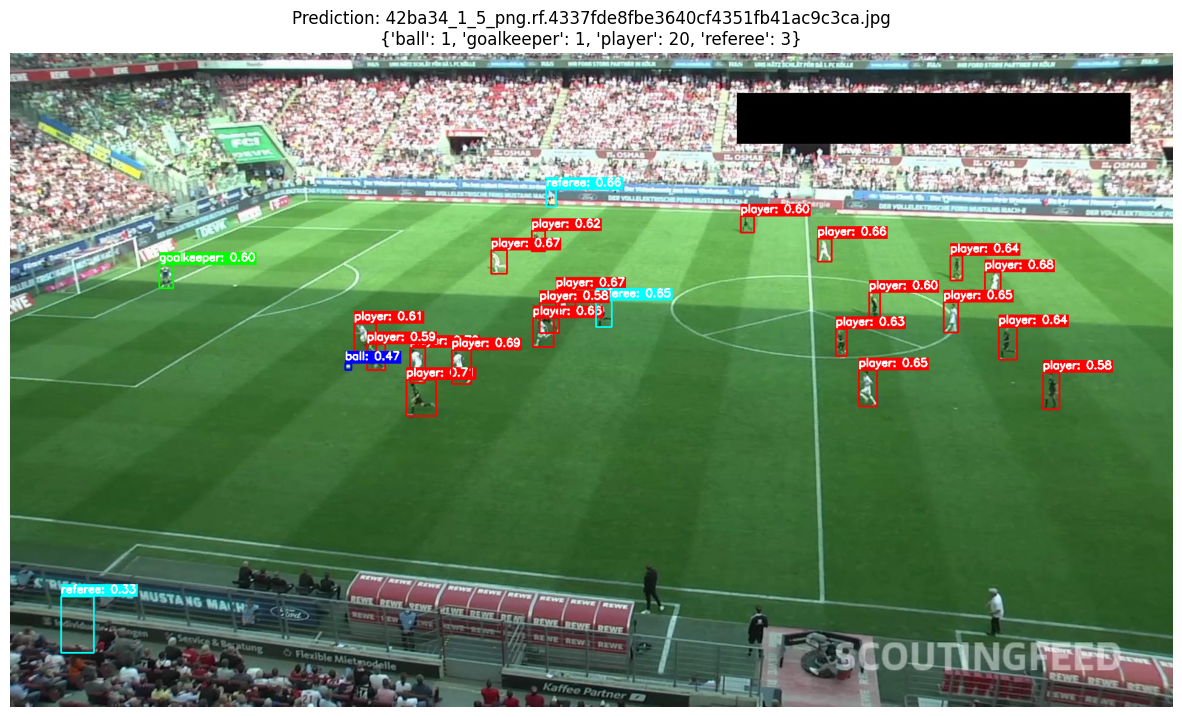


Predicting on: /kaggle/input/football-players-detection-dataset/test/images/42ba34_5_5_png.rf.ceb556bd4c92d41496ae1d8c56600c4a.jpg

image 1/1 /kaggle/input/football-players-detection-dataset/test/images/42ba34_5_5_png.rf.ceb556bd4c92d41496ae1d8c56600c4a.jpg: 736x1280 1 goalkeeper, 18 players, 1 referee, 111.4ms
Speed: 6.7ms preprocess, 111.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


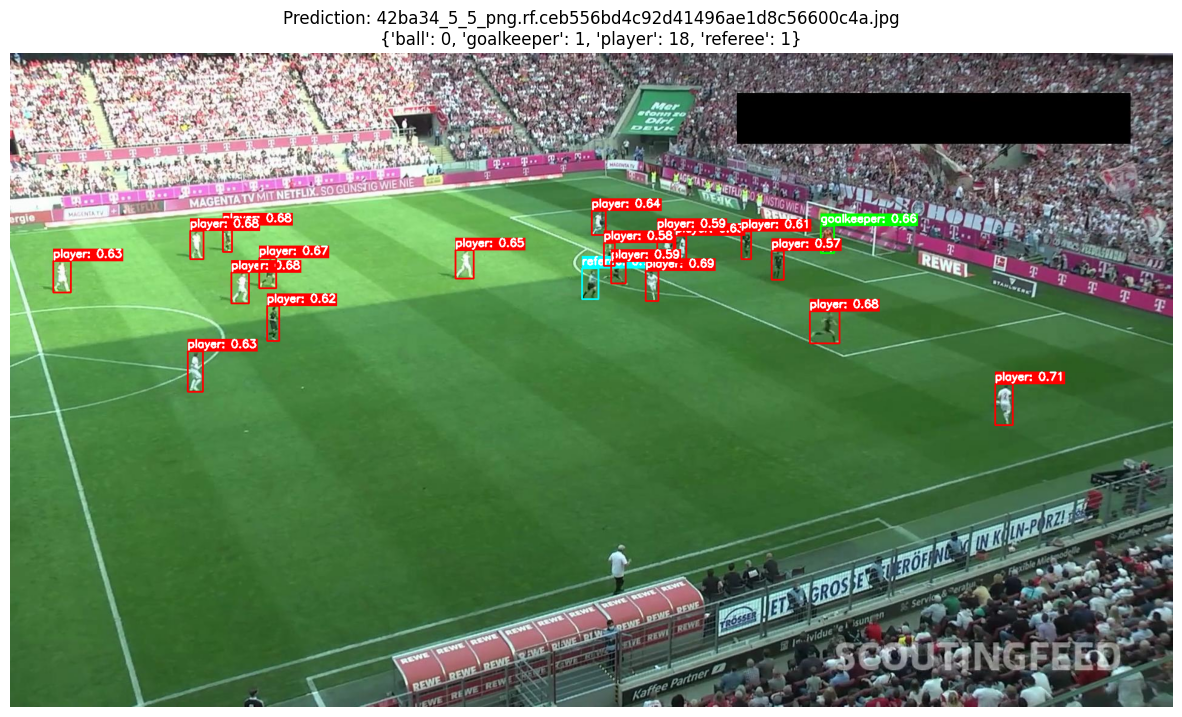


Predicting on: /kaggle/input/football-players-detection-dataset/test/images/4b770a_1_4_png.rf.5a45b3b841a06de414ceb802e34c136f.jpg

image 1/1 /kaggle/input/football-players-detection-dataset/test/images/4b770a_1_4_png.rf.5a45b3b841a06de414ceb802e34c136f.jpg: 736x1280 1 goalkeeper, 20 players, 3 referees, 112.0ms
Speed: 8.8ms preprocess, 112.0ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


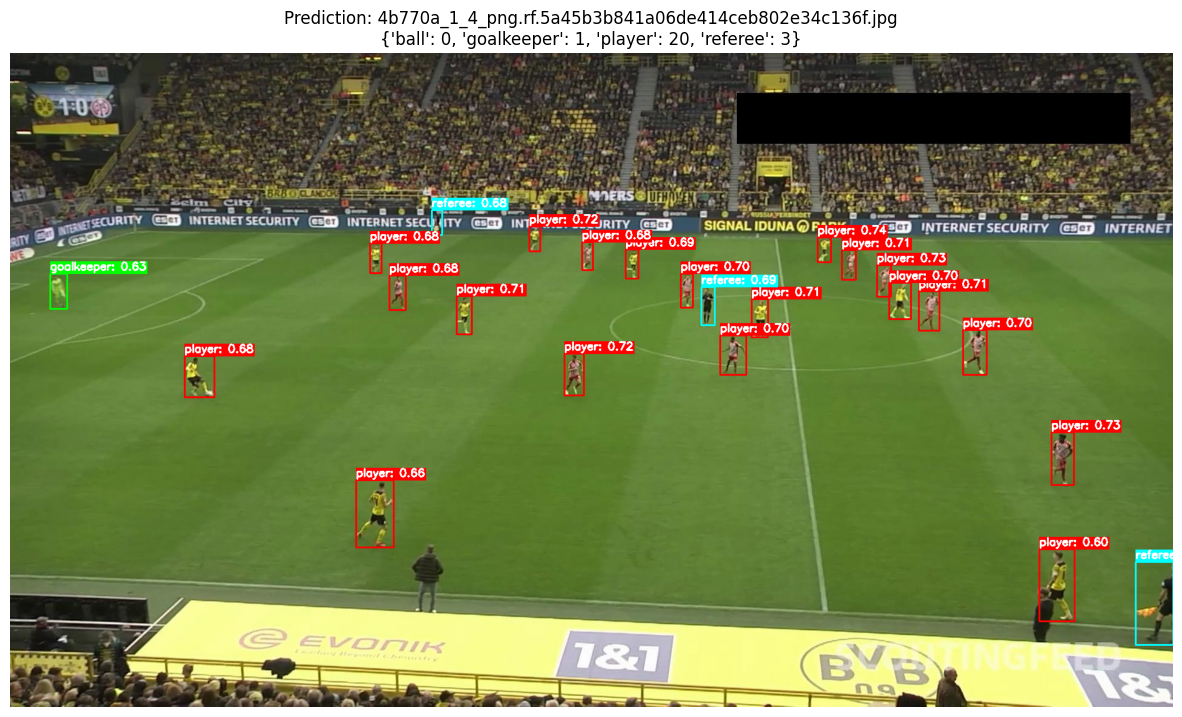

In [ ]:
test_img_dir = os.path.join(main_path, 'test', 'images')
test_image_paths = sorted(glob.glob(os.path.join(test_img_dir, '*.*')))[:5]

if not test_image_paths:
    print(f"Không tìm thấy ảnh nào trong thư mục test: {test_img_dir}")
else:
    for img_path in test_image_paths:
        print(f"\nPredicting on: {img_path}")
        
        # Sử dụng kỹ thuật Test Time Augmentation (TTA) và Ensemble
        # TTA thực hiện dự đoán trên nhiều biến thể của cùng một ảnh và kết hợp kết quả
        results_pred = models[0].predict(
            source=img_path,
            imgsz=IMG_SIZE,
            conf=CONF_THRESHOLD,
            iou=NMS_IOU_THRESHOLD,
            device=DEVICE,
            augment=True,  # Kích hoạt TTA
            save=False
        )
        
        result = results_pred[0]
        
        img_orig = result.orig_img
        img_with_boxes = img_orig.copy()
        boxes = result.boxes
        
        class_counts = {name: 0 for name in class_names}
        
        for box in boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            conf = box.conf[0].item()
            cls_id = int(box.cls[0].item())
            class_name = result.names[cls_id]
            class_counts[class_name] += 1
            
            if class_name == "ball":
                color = (255, 0, 0)  # Đỏ cho bóng
            elif class_name == "goalkeeper":
                color = (0, 255, 0)  # Xanh lá cho thủ môn
            elif class_name == "player":
                color = (0, 0, 255)  # Xanh dương cho cầu thủ
            else:  # referee
                color = (255, 255, 0)  # Vàng cho trọng tài
            
            cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), color, 2)
            
            label = f"{class_name}: {conf:.2f}"
            (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(img_with_boxes, (x1, y1 - text_height - baseline), (x1 + text_width, y1), color, -1)
            cv2.putText(img_with_boxes, label, (x1, y1 - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        
        plt.figure(figsize=(15, 15))
        plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
        plt.title(f"Prediction: {os.path.basename(img_path)}\n{class_counts}")
        plt.axis('off')
        plt.show()